In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torchvision.transforms import v2
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import torch

In [42]:
dataset = SVHNDataset(split="train", 
                      image_transform=v2.Compose([
                        v2.ToTensor(),
                        v2.Resize((64, 64))  
                      ]))

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [43]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [45]:
anchors = torch.Tensor([[0.2, 0.8]])

In [70]:
for x in dataloader:
    target = build_targets(
        bboxes=x["bboxes"],
        labels=x["labels"],
        anchors=anchors,
        grid_size=(2, 2),
        num_classes=10
    )

    break

In [72]:
target[0, :, 0, 0]

tensor([-0.1875, -0.1744, -0.0189,  0.0834,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

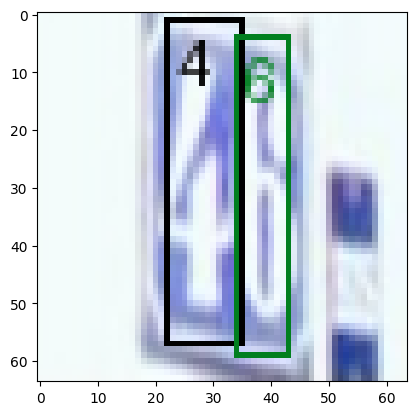

In [38]:
item = dataset[0]
plt.imshow(
    draw_bounding_boxes(
        image=item["image"],
        bboxes=box_convert(item["bbox"], in_fmt="xywh", out_fmt="xyxy"),
        labels=item["labels"]
    )
)